# Segmentación RFM+t y PAM

### 1. Librerias:

In [1]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar
import seaborn as sns
import squarify

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Funciones:

Importante para el tratamiento de fechas

In [4]:
def convStrDate(cadena):
    cadena = str(cadena)
    fec = cadena[0:4]+'-'+cadena[4:7]+'-01'
    return fec

In [5]:
def add_months(date, months):
    month = date.month - 1 + months
    year = date.year + month // 12
    month = month % 12 + 1
    day = min(date.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

### 3. Extracción Base de Datos:

Extraemos la base de datos de consumo, en este caso no se considerarálos rubros, ya que, trataremos de aprovechar la esencia de las variables básicas como es la periodicidad y monto

In [6]:
dataFramePre = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datos/03 dataBaseConsumo.txt",delimiter='|', encoding='latin-1')
dataFramePre = dataFramePre.drop(['grupoGiro'],axis=1)
dataFramePre.head()

,codmes,cliente,edad,ingreso,sexo,flgLimaProv,flgAfBxi,monto,trx
0,201611,32572,[1. <=25],[2. <=1500],F,1.0,1.0,12,1
1,201611,29843,[1. <=25],[3. <=2500],F,0.0,1.0,22,1
2,201611,30033,[2. <=30],[2. <=1500],F,0.0,1.0,10,1
3,201612,3847,[7. > 55],[3. <=2500],M,1.0,0.0,350,4
4,201611,33131,[1. <=25],[2. <=1500],F,1.0,1.0,65,2


Creamos la base de datos con todos los periodos (histórico) de consumo e incluimos una variable de índice (ind) para los posteriores tratamientos.

In [7]:
# Creamos un campo de fecha para que nos ayude a tratar la agregación y disminución de meses
dataFrame = pd.DataFrame()
dataFrame = dataFramePre.copy()

dataFrame['fecha'] = dataFramePre['codmes'].apply(convStrDate)
dataFrame['fecha'] = pd.to_datetime(dataFrame['fecha'])

# Creamos Base de Datos con las variables de interés:
dbGroup = dataFrame.groupby(['fecha','cliente']).agg({'trx':sum,'monto':sum})
dbGroup['ind'] = 1
dbGroup = dbGroup.reset_index()

In [8]:
dataFrame.head()

,codmes,cliente,edad,ingreso,sexo,flgLimaProv,flgAfBxi,monto,trx,fecha
0,201611,32572,[1. <=25],[2. <=1500],F,1.0,1.0,12,1,2016-11-01
1,201611,29843,[1. <=25],[3. <=2500],F,0.0,1.0,22,1,2016-11-01
2,201611,30033,[2. <=30],[2. <=1500],F,0.0,1.0,10,1,2016-11-01
3,201612,3847,[7. > 55],[3. <=2500],M,1.0,0.0,350,4,2016-12-01
4,201611,33131,[1. <=25],[2. <=1500],F,1.0,1.0,65,2,2016-11-01


In [9]:
dbGroup.head()

,fecha,cliente,trx,monto,ind
0,2016-11-01,1,5,266,1
1,2016-11-01,2,8,453,1
2,2016-11-01,3,7,1676,1
3,2016-11-01,4,15,1186,1
4,2016-11-01,6,1,4,1


### 4. Universo:

Elegiremos una cosecha referente que servirá como nuestro universo de clientes el cual analizaremos su comportamiento, esta cosecha puede ser un mes o varios meses.
 - Recordar: tiene que ser a nivel de cliente

In [10]:
# Fecha mínima y máximo:
print(dbGroup['fecha'].min())
print(dbGroup['fecha'].max())

2016-11-01 00:00:00
2017-10-01 00:00:00


In [11]:
# Filtramos la cosecha para el universo:
dbUniv = dbGroup[dbGroup['fecha']=='2017-10-01'] # cogemos la más reciente porque nos ayudará a tener información historica , a diferencia la fecha minima ya que
# detras de 2016-11 no hay data
dbUniv = dbUniv.rename(columns={'fecha':'periodo'})
dbUniv = dbUniv[['periodo','cliente']]
dbUniv.head()

,periodo,cliente
150227,2017-10-01,1
150228,2017-10-01,2
150229,2017-10-01,3
150230,2017-10-01,4
150231,2017-10-01,5


Para poder relacionar nuestra base Universo con la base histórica de consumo, vamos agregar las fechas anteriores (-1, -2, -3) para que posteriormente podamos hacer merge

In [12]:
# Incluiremos fechas de los 3 últimos meses 
for i in range(3):
    dbUniv['fec_'+str(i+1)] =\
    pd.to_datetime(dbUniv.apply(lambda x: add_months(x['periodo'],-(i+1)),axis=1))
dbUniv.head()

,periodo,cliente,fec_1,fec_2,fec_3
150227,2017-10-01,1,2017-09-01,2017-08-01,2017-07-01
150228,2017-10-01,2,2017-09-01,2017-08-01,2017-07-01
150229,2017-10-01,3,2017-09-01,2017-08-01,2017-07-01
150230,2017-10-01,4,2017-09-01,2017-08-01,2017-07-01
150231,2017-10-01,5,2017-09-01,2017-08-01,2017-07-01


### 5. Desarrollo Base de Datos para el RFM +t:

Pegamos la información de Tenencia y de consumo de los 3 últimos meses

In [13]:
dbFinal = pd.merge(dbUniv,dbGroup[['fecha','cliente','monto','trx','ind']], how='left',
                   left_on=['fec_1','cliente'],right_on = ['fecha','cliente'])
dbFinal = pd.merge(dbFinal,dbGroup[['fecha','cliente','monto','trx','ind']], how='left',
                   left_on=['fec_2','cliente'],right_on = ['fecha','cliente'])
dbFinal = pd.merge(dbFinal,dbGroup[['fecha','cliente','monto','trx','ind']], how='left',
                   left_on=['fec_3','cliente'],right_on = ['fecha','cliente'])

In [14]:
dbFinal.head()

,periodo,cliente,fec_1,fec_2,fec_3,fecha_x,monto_x,trx_x,ind_x,fecha_y,monto_y,trx_y,ind_y,fecha,monto,trx,ind
0,2017-10-01,1,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN,2017-08-01,210.0,2.0,1.0,2017-07-01,346.0,5.0,1.0
1,2017-10-01,2,2017-09-01,2017-08-01,2017-07-01,2017-09-01,228.0,1.0,1.0,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,2017-10-01,3,2017-09-01,2017-08-01,2017-07-01,2017-09-01,1691.0,9.0,1.0,2017-08-01,586.0,2.0,1.0,2017-07-01,255.0,2.0,1.0
3,2017-10-01,4,2017-09-01,2017-08-01,2017-07-01,2017-09-01,2650.0,16.0,1.0,2017-08-01,1701.0,11.0,1.0,2017-07-01,601.0,8.0,1.0
4,2017-10-01,5,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN,2017-08-01,7.0,1.0,1.0,NaT,NaN,NaN,NaN


In [15]:
dbFinal['M_1'] = dbFinal['ind_x'].apply(lambda x: 1 if x==1 else 0)
dbFinal['monto_1'] = dbFinal['monto_x'].fillna(0)
dbFinal['trx_1'] = dbFinal['trx_x'].fillna(0)

dbFinal['M_2'] = dbFinal['ind_y'].apply(lambda x: 1 if x==1 else 0)
dbFinal['monto_2'] = dbFinal['monto_y'].fillna(0)
dbFinal['trx_2'] = dbFinal['trx_y'].fillna(0)

dbFinal['M_3'] = dbFinal['ind'].apply(lambda x: 1 if x==1 else 0)
dbFinal['monto_3'] = dbFinal['monto'].fillna(0)
dbFinal['trx_3'] = dbFinal['trx'].fillna(0)

dbFinal = dbFinal[['periodo','cliente','M_1','M_2','M_3','monto_1','monto_2','monto_3','trx_1','trx_2','trx_3']]

In [16]:
dbFinal.head()

,periodo,cliente,M_1,M_2,M_3,monto_1,monto_2,monto_3,trx_1,trx_2,trx_3
0,2017-10-01,1,0,1,1,0.0,210.0,346.0,0.0,2.0,5.0
1,2017-10-01,2,1,0,0,228.0,0.0,0.0,1.0,0.0,0.0
2,2017-10-01,3,1,1,1,1691.0,586.0,255.0,9.0,2.0,2.0
3,2017-10-01,4,1,1,1,2650.0,1701.0,601.0,16.0,11.0,8.0
4,2017-10-01,5,0,1,0,0.0,7.0,0.0,0.0,1.0,0.0


#### 5.1 Formando R + F + M + T

A partir de la información de los 3 últimos meses damos forma a las variables R, F y M usando la libreria numpy para trabajar las condiciones

In [17]:
dbFinal['frec'] = dbFinal['M_1']+dbFinal['M_2']+dbFinal['M_3']
dbFinal['rec'] = np.where(dbFinal['M_1']==1,3,np.where(dbFinal['M_2']==1,2,np.where(dbFinal['M_3']==1,1,0)))
dbFinal['monto3um'] = np.where(dbFinal['frec']>0,
                               (dbFinal['monto_1']+dbFinal['monto_2']+dbFinal['monto_3'])/dbFinal['frec'],0) #monto promedio
dbFinal['trx3um'] = np.where(dbFinal['frec']>0, 
                             dbFinal['trx_1']+dbFinal['trx_2']+dbFinal['trx_3']/dbFinal['frec'],0)    #transacciones promedio

In [18]:
dbFinal.head()

,periodo,cliente,M_1,M_2,M_3,monto_1,monto_2,monto_3,trx_1,trx_2,trx_3,frec,rec,monto3um,trx3um
0,2017-10-01,1,0,1,1,0.0,210.0,346.0,0.0,2.0,5.0,2,2,278.000000,4.500000
1,2017-10-01,2,1,0,0,228.0,0.0,0.0,1.0,0.0,0.0,1,3,228.000000,1.000000
2,2017-10-01,3,1,1,1,1691.0,586.0,255.0,9.0,2.0,2.0,3,3,844.000000,11.666667
3,2017-10-01,4,1,1,1,2650.0,1701.0,601.0,16.0,11.0,8.0,3,3,1650.666667,29.666667
4,2017-10-01,5,0,1,0,0.0,7.0,0.0,0.0,1.0,0.0,1,2,7.000000,1.000000


Analizando valores de monto y transacciones

In [19]:
'''Analizando el valor de "MONTO"'''
corte = dbFinal['monto3um'][dbFinal['monto3um']>0].median()
print(f'La mediana de Monto es: {corte}')

La mediana de Monto es: 165.33333333333334


In [20]:
'''Analizando el valor de "transacciones"'''
corte2 = dbFinal['trx3um'][dbFinal['trx3um']>0].median()
print(f'La mediana de la cantidad de transacciones es: {corte2}')

La mediana de la cantidad de transacciones es: 4.0


#### 5.2 Etiqueta de Monto, trx y filtros

Este paso es muy importante porque se hacen los últimos ajustes de la base de datos del RFM + t, suelen aparecer algunas anomalias, en caso sean mínimas podrian extraerse o corregir, en caso sea muy voluminoso habría que revisar la fuente de información 

In [21]:
dbFinal['monto'] = np.where(dbFinal['monto3um']>=corte,'alto',np.where(dbFinal['monto3um']>0,'bajo','None')) # categorizamos el monto
dbFinal['trx_f'] = np.where(dbFinal['trx3um']>=corte2,'alto',np.where(dbFinal['trx3um']>0,'bajo','None')) # categorizamos las transacciones

dbFinal = dbFinal[['periodo','cliente','monto3um','trx3um','rec','frec','monto','trx_f']]
# Limpiando

dbFinal = dbFinal[~((dbFinal['frec']>0) & (dbFinal['monto3um']==0))] # para quitar registros donde haya compra pero no figure el monto

In [21]:
dbFinal.head()

,periodo,cliente,monto3um,trx3um,rec,frec,monto,trx_f
0,2017-10-01,1,278.000000,4.500000,2,2,alto,alto
1,2017-10-01,2,228.000000,1.000000,3,1,alto,bajo
2,2017-10-01,3,844.000000,11.666667,3,3,alto,alto
3,2017-10-01,4,1650.666667,29.666667,3,3,alto,alto
4,2017-10-01,5,7.000000,1.000000,2,1,bajo,bajo


# Herramienta PAM
- Partitioning Around Medoids

### 1. Librerias:

In [22]:
pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from kmodes.kmodes import KModes
from sklearn import preprocessing

### 2. Base de Datos y etiquetado:

Al preparar la base de datos, es necesario que las variables categóricas tengan una etiqueta, para ello haremos uso del LabelEncoder()

In [24]:
dbKmodes = pd.DataFrame()
dbKmodes = dbFinal.copy()

cod = preprocessing.LabelEncoder()
dbKmodes = dbKmodes[['rec','frec','monto','trx_f']].apply(cod.fit_transform)

In [25]:
dbFinal.head()

,periodo,cliente,monto3um,trx3um,rec,frec,monto,trx_f
0,2017-10-01,1,278.000000,4.500000,2,2,alto,alto
1,2017-10-01,2,228.000000,1.000000,3,1,alto,bajo
2,2017-10-01,3,844.000000,11.666667,3,3,alto,alto
3,2017-10-01,4,1650.666667,29.666667,3,3,alto,alto
4,2017-10-01,5,7.000000,1.000000,2,1,bajo,bajo


In [26]:
dbKmodes.head() # label encoder  coloca el orden 0,1,2 ... dependiendo de la proporcion de la clase mayoritaria en cada variable, hay mas clientes con valor alto en monto, por ello se le coloca '0'

,rec,frec,monto,trx_f
0,2,2,1,1
1,3,1,1,2
2,3,3,1,1
3,3,3,1,1
4,2,1,2,2


### 3. Modelo Clustering:

Realizamos varias pruebas de clustering con el algorimo KMedois, cuyo algoritmo trabaja con variables categóricas.

In [27]:
cost=[]
cluster=[]

for i in list(range(1,9)):
    model = KModes(n_clusters=i, init='Cao', n_init=10, verbose=1)
    cluster.append(model.fit_predict(dbKmodes))
    cost.append(model.cost_)
print(model.cluster_centroids_)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 30628.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 22121.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 10025.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 889, cost: 8058.0
Run 1, iteration: 2/100, moves: 0, cost: 8058.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing cluster

### 4. Evolución de Cluster Vs Costo:

Este gráfico nos ayudará a analizar la evolución de los valores del costo cada vez que sugiere cierto número de cluster, lo ideal es tomar aquellos costos menores

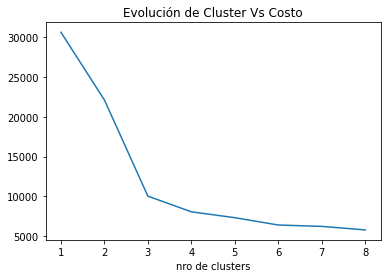

In [28]:
rango=np.array(range(1,len(cost)+1))
plt.plot(rango,cost)
plt.title('Evolución de Cluster Vs Costo')
plt.xlabel('nro de clusters')
plt.show()

### 5. Análisis de Clusters:

In [29]:
numClus=[2,3,4,5,6,7,8]

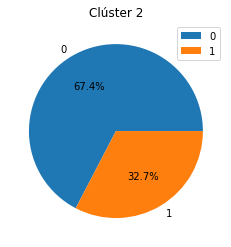

         ctdCliente  pctCliente
cluster                        
0              9314       67.35
1              4516       32.65




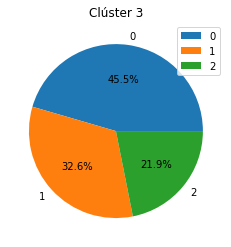

         ctdCliente  pctCliente
cluster                        
0              6290       45.48
1              4516       32.65
2              3024       21.87




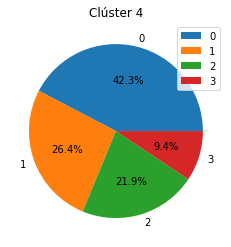

         ctdCliente  pctCliente
cluster                        
0              5857       42.35
1              3654       26.42
2              3024       21.87
3              1295        9.36




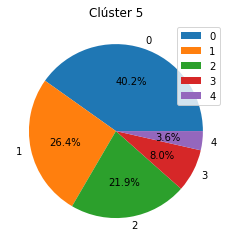

         ctdCliente  pctCliente
cluster                        
0              5556       40.17
1              3654       26.42
2              3024       21.87
3              1105        7.99
4               491        3.55




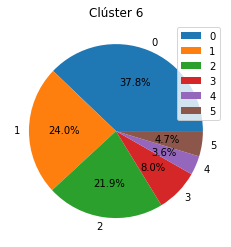

         ctdCliente  pctCliente
cluster                        
0              5235       37.85
1              3325       24.04
2              3024       21.87
3              1105        7.99
4               491        3.55
5               650        4.70




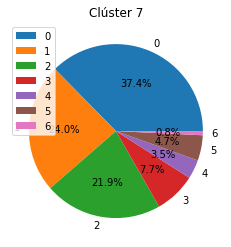

         ctdCliente  pctCliente
cluster                        
0              5168       37.37
1              3325       24.04
2              3024       21.87
3              1066        7.71
4               491        3.55
5               650        4.70
6               106        0.77




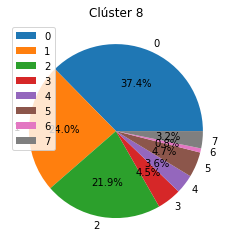

         ctdCliente  pctCliente
cluster                        
0              5168       37.37
1              3325       24.04
2              3024       21.87
3               623        4.50
4               491        3.55
5               650        4.70
6               106        0.77
7               443        3.20




In [30]:
copy =  pd.DataFrame()
for i in numClus:
    # Distribución de los grupos por clúster:
    copy['cluster'] = cluster[i-1]
    ctdGrupo =  pd.DataFrame()
    ctdGrupo['ctdCliente']=copy.groupby('cluster').size()
    ctdGrupo['pctCliente']=np.round(100*ctdGrupo['ctdCliente']/ctdGrupo['ctdCliente'].sum(),2)
   
    # gráfico de los grupos según su distribución:
    plt.pie(ctdGrupo['pctCliente'], labels=ctdGrupo.index, autopct='%1.1f%%')
    plt.title('Clúster '+str(i))
    plt.legend()
    plt.show()
    print(ctdGrupo)      
    print('\n')

### 6. Base Final - Cluster

#### Agrupación inicial:

In [31]:
nCluster = int(input('Ingrese la cantidad de cluster: '))

Ingrese la cantidad de cluster: 6


In [32]:
df_RFMT = pd.DataFrame()
df_RFMT = dbFinal.copy()
# Agregamos la etiqueta de los clusters:
df_RFMT['cluster'] = cluster[nCluster-1]

In [33]:
df_RFMT.head()

,periodo,cliente,monto3um,trx3um,rec,frec,monto,trx_f,cluster
0,2017-10-01,1,278.000000,4.500000,2,2,alto,alto,5
1,2017-10-01,2,228.000000,1.000000,3,1,alto,bajo,4
2,2017-10-01,3,844.000000,11.666667,3,3,alto,alto,0
3,2017-10-01,4,1650.666667,29.666667,3,3,alto,alto,0
4,2017-10-01,5,7.000000,1.000000,2,1,bajo,bajo,3


#### Análisis de correlación de grupos


In [34]:
columns = ['rec','frec','monto','trx_f']

In [35]:
df_cluster = pd.DataFrame()
df_cluster = dbKmodes.copy()
df_cluster['cluster'] = cluster[nCluster-1]
df_cluster.head()

,rec,frec,monto,trx_f,cluster
0,2,2,1,1,5
1,3,1,1,2,4
2,3,3,1,1,0
3,3,3,1,1,0
4,2,1,2,2,3


In [36]:
# calculamos los centroides de los clusteres:
copy = pd.DataFrame()
centroide = pd.DataFrame()

copy = df_cluster.copy()
for columnName in columns:
    centroide[columnName] = copy.groupby('cluster').agg(columnName).mean()
centroide

,rec,frec,monto,trx_f
cluster,,,,
0,2.974403,2.761032,1.249475,1.044126
1,2.880000,1.955789,1.918797,1.877895
2,0.000000,0.000000,0.000000,0.000000
3,1.563801,1.000000,1.828054,1.952036
4,2.226069,1.000000,1.000000,2.000000
5,2.000000,1.920000,1.190769,1.315385


<ipython-input-37-3f7a1d9fa861>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


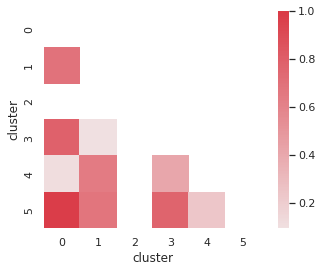

In [37]:
dfTransp = centroide.T
corr = dfTransp.corr()

def plot_correlations(corr):
    sns.set(style="white")
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(abs(corr), mask=mask, cmap=cmap, vmax=1, center=0,square=True) 
    
plot_correlations(corr)

In [38]:
corr

cluster,0,1,2,3,4,5
cluster,,,,,,
0,1.000000,0.688366,NaN,-0.786880,0.114218,0.978526
1,0.688366,1.000000,NaN,-0.094730,0.643908,0.672879
2,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.786880,-0.094730,NaN,1.000000,0.411465,-0.763499
4,0.114218,0.643908,NaN,0.411465,1.000000,0.238008
5,0.978526,0.672879,NaN,-0.763499,0.238008,1.000000


* Debido a que el cluser 4 tiene menor porcentaje de clientes se buscará asociarlo con aquel cluster con el que tenga mayor correlación, en este caso, el cluster 1.

* De mismo modo buscaré asociar el cluster 5 con el 0.

#### Reagrupación:

In [39]:
#Reagrupar
clusFinal =  pd.DataFrame()
clusFinal['clusterFin'] = cluster[nCluster-1]

clusFinal = clusFinal.replace(4,1)
clusFinal = clusFinal.replace(5,0)

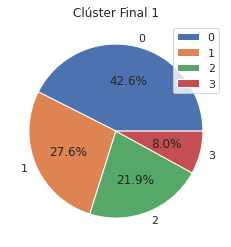

            ctdCliente  pctCliente
clusterFin                        
0                 5885       42.55
1                 3816       27.59
2                 3024       21.87
3                 1105        7.99




In [40]:
# Distribución de los grupos por clúster Final:
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['ctdCliente']=clusFinal.groupby('clusterFin').size()
cantidadGrupo['pctCliente']=round(100*cantidadGrupo['ctdCliente']/cantidadGrupo['ctdCliente'].sum(),2)
    
# gráfico de los grupos según su distribución:
plt.pie(cantidadGrupo['pctCliente'], labels=cantidadGrupo.index, autopct='%1.1f%%')
plt.title('Clúster Final '+ str(len(set(clusFinal))))
plt.legend()
plt.show()
print(cantidadGrupo)       
print('\n')

* Asociando nueva agrupación :

In [41]:
df_RFMT['cluster'] = clusFinal

### 7. RFM Método Analítico:

#### 7.1 Características de los clusters:

A partir de las carcterísticas agrupados por los cluster, procedemos a analizar quienes son y con ello llegar a la conclusión.

In [42]:
resClus = df_RFMT.groupby('cluster').agg({'cliente':'count','rec':'mean','frec':'mean','monto3um':'mean', 'trx3um':'mean'})\
                                 .sort_values(by='cluster')
resClus = resClus.reset_index()
resClus['%'] = round(100*resClus['cliente']/df_RFMT.count()[0],1)
print(f'Clientes Total: {df_RFMT.count()[0]}\n')
print(resClus)

Clientes Total: 13830

   cluster  cliente       rec      frec    monto3um    trx3um     %
0      0.0     5883  2.397076  2.076662  513.582016  7.264208  42.5
1      1.0     3816  2.287474  1.731132  236.781228  4.210561  27.6
2      2.0     3024  1.424272  1.100860  168.807044  3.155589  21.9
3      3.0     1105  1.927602  1.492308  247.295475  4.007692   8.0


#### 7.2 Etiquetado del segmento:

In [43]:
resClus['segmento']=np.where(resClus['cluster']==0,'potecialmente fidelizado/fidelizado',
                    np.where(resClus['cluster']==1,'maduracion',
                    np.where(resClus['cluster']==2,'potecialmente inactivos/desganados',
                    np.where(resClus['cluster']==3,'reengachados','None'))))                 

In [44]:
resClus.head()

,cluster,cliente,rec,frec,monto3um,trx3um,%,segmento
0,0.0,5883,2.397076,2.076662,513.582016,7.264208,42.5,potecialmente fidelizado/fidelizado
1,1.0,3816,2.287474,1.731132,236.781228,4.210561,27.6,maduracion
2,2.0,3024,1.424272,1.100860,168.807044,3.155589,21.9,potecialmente inactivos/desganados
3,3.0,1105,1.927602,1.492308,247.295475,4.007692,8.0,reengachados


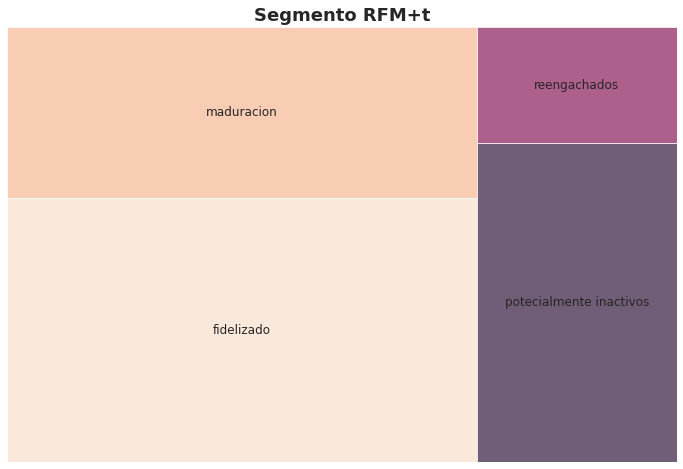

In [45]:
#Debe importar "squarify"
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
squarify.plot(sizes=resClus['%'], 
              label=['fidelizado',
                     'maduracion',
                     'potecialmente inactivos',
                     'reengachados'], alpha=0.7 )
plt.title("Segmento RFM+t",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# Conclusiones



1.  Agregar la variable transacciones hace que la distribución de clusters varie en gran medida.
2. Hay una gran porpoción de clientes desganados/potecialmente inactivos, por lo que la compañía tiene que enfocarse en reengancharlos lo más pronto posible.
3. Para que los clientes potencialmente inactivos entren a una etapa de maduración primero deben ser reengachados para aumentar su recencia de compras y podrían recibir ofertas atractivas o bonos de consumo para aumentar la frecuencia de sus compras con la tarjeta y por ende los montos asociados a estos movimientos. De este modo irán madurando como usuarios hasta poder ser usuarios fieles a la compañia.


